# 03 Análisis: Indicadores de Desarrollo vs Cambio Climático

En este notebook exploraremos cómo distintos indicadores de desarrollo (PIB, población, consumo de energía, participación de renovables, etc.) se relacionan con el cambio climático, medido a través de emisiones de CO₂ y de intensidad de carbono. Generaremos visualizaciones y métricas para evaluar el papel de las energías renovables en la mitigación de las emisiones.


In [221]:
# Celda de Código 1: Imports iniciales y configuración
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


## 1. Carga de datos

- **World Development Indicators** (`P_Data_Extract_From_World_Development_Indicators.xlsx`): múltiples indicadores por país y año.  
- **PIB** (`API_NY.GDP.MKTP.CD_DS2_en_excel_v2_85096.xls`): PIB total por país y año.  
- **Emisiones de CO₂** (`tidy_format_co2_emission_dataset.csv`): tasa anual de emisiones de CO₂ por país.


In [222]:
# Celda de Código 2: Carga de archivos
# 1. Desarrollo (WDI)
wdi_path = "../../data/fuentes/economicos/P_Data_Extract_From_World_Development_Indicators.xlsx"
xls_wdi  = pd.ExcelFile(wdi_path)
df_wdi   = xls_wdi.parse("Data")

# 2. PIB
gdp_path = "../../data/fuentes/economicos/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_85096.xls"
df_gdp   = pd.read_excel(gdp_path, skiprows=3)

# 3. Emisiones CO2
co2_path = "../../data/fuentes/climaticos/tidy_format_co2_emission_dataset.csv"
df_co2   = pd.read_csv(co2_path)


## 2. Transformación a formato “long”

Normalizamos columnas y pivotamos cada dataset de formato ancho a largo.


In [223]:
# Celda de Código 3: Melt WDI → df_dev_long
year_cols = [c for c in df_wdi.columns if c.endswith("]")]
df_dev_long = (
    df_wdi
      .melt(
         id_vars=["Country Name","Country Code","Series Name","Series Code"],
         value_vars=year_cols,
         var_name="Year",
         value_name="Value"
       )
)
df_dev_long["Year"] = df_dev_long["Year"].str.extract(r"(\d{4})").astype(int)
df_dev_long["Value"] = pd.to_numeric(df_dev_long["Value"], errors="coerce")


In [224]:
# Celda de Código 4: Melt GDP → df_gdp_long
year_cols_gdp = [c for c in df_gdp.columns if c.isdigit()]
df_gdp_long = (
    df_gdp
      .melt(
         id_vars=["Country Name","Country Code","Indicator Name","Indicator Code"],
         value_vars=year_cols_gdp,
         var_name="Year",
         value_name="GDP"
       )
      .dropna(subset=["GDP"])
)
df_gdp_long["Year"] = df_gdp_long["Year"].astype(int)
df_gdp_long["GDP"]  = pd.to_numeric(df_gdp_long["GDP"], errors="coerce")


In [225]:
# Celda de Código 5: Limpieza de emisiones de CO2 → df_co2_clean
df_co2_clean = (
    df_co2.rename(columns={
      "Country": "Country Name",
      "Year":    "Year",
      "CO2EmissionRate (mt)": "CO2"
    })
    .dropna(subset=["CO2"])
)
df_co2_clean["CO2"] = pd.to_numeric(df_co2_clean["CO2"], errors="coerce")


## 3. Selección de indicadores clave

Nos interesa evaluar:
- **Energías renovables**:  
  - `EG.ELC.RNWX.ZS` (% electricidad renovable)  
  - `EG.ELC.FOSL.ZS` (% electricidad fósil)  
- **Consumo energético**:  
  - `EG.USE.PCAP.KG.OE` (kg petróleo eq. per cápita)  
- **Intensidad de carbono**:  
  - `EN.GHG.CO2.RT.GDP.KD` (kg CO₂ por US$ constante)  
  - `EN.GHG.CO2.RT.GDP.PP.KD` (kg CO₂ por US$ PPA)


In [226]:
# Celda de Código 6: Filtrar df_dev_long para nuestros indicadores
indic_codes = [
  "EG.ELC.RNWX.ZS","EG.ELC.FOSL.ZS",
  "EG.USE.PCAP.KG.OE",
  "EN.GHG.CO2.RT.GDP.KD","EN.GHG.CO2.RT.GDP.PP.KD"
]
df_ind = df_dev_long[df_dev_long["Series Code"].isin(indic_codes)].copy()


## 4. Pivot a formato ancho

Creamos un DataFrame con una columna por indicador, índice por país y año.


In [227]:
# Celda de Código 7: Pivot indicador → df_wide
df_wide = (
    df_ind
      .pivot_table(
         index=["Country Name","Country Code","Year"],
         columns="Series Code",
         values="Value"
      )
      .reset_index()
)
# Renombramos para facilitar
df_wide = df_wide.rename(columns={
    "EG.ELC.RNWX.ZS":    "pct_renovables",
    "EG.ELC.FOSL.ZS":    "pct_fosiles",
    "EG.USE.PCAP.KG.OE": "uso_energia_pc",
    "EN.GHG.CO2.RT.GDP.KD":   "intensidad_constante",
    "EN.GHG.CO2.RT.GDP.PP.KD":"intensidad_ppa"
})


## 5. Unión de todos los datos

Fusionamos:
1. **df_wide** (indicadores de desarrollo)  
2. **df_gdp_long**  
3. **df_co2_clean**  
en un solo DataFrame para análisis conjunto.


In [228]:
# Celda de Código 8: Merge de desarrollo + PIB + CO2
# 5.1 Ajustes previos
df_gdp_sub = df_gdp_long.rename(columns={"Country Name":"Country Name","Year":"Year","GDP":"GDP"})
df_co2_sub = df_co2_clean.rename(columns={"Country Name":"Country Name","Year":"Year","CO2":"CO2"})

# 5.2 Merge en cadena
df_all = (
    df_wide
      .merge(df_gdp_sub, on=["Country Name","Country Code","Year"], how="inner")
      .merge(df_co2_sub, on=["Country Name","Year"], how="inner")
)
print("Dimensiones final:", df_all.shape)
df_all.head()


Dimensiones final: (4426, 11)


,Country Name,Country Code,Year,pct_fosiles,pct_renovables,intensidad_constante,intensidad_ppa,Indicator Name,Indicator Code,GDP,CO2
0,Afghanistan,AFG,2000,NaN,NaN,0.172592,0.032892,GDP (current US$),NY.GDP.MKTP.CD,3.521418e+09,0.0
1,Afghanistan,AFG,2001,NaN,NaN,0.175818,0.033507,GDP (current US$),NY.GDP.MKTP.CD,2.813572e+09,0.0
2,Afghanistan,AFG,2002,NaN,NaN,0.134587,0.025649,GDP (current US$),NY.GDP.MKTP.CD,3.825701e+09,0.0
3,Afghanistan,AFG,2003,NaN,NaN,0.134583,0.025648,GDP (current US$),NY.GDP.MKTP.CD,4.520947e+09,0.0
4,Afghanistan,AFG,2004,NaN,NaN,0.117716,0.022434,GDP (current US$),NY.GDP.MKTP.CD,5.224897e+09,0.0


## 6. Gráfica 1: % Renovables vs Intensidad de Carbono

Visualizamos la relación entre la penetración de renovables y la intensidad de carbono (kg CO₂/US$) en el año más reciente con datos completos.


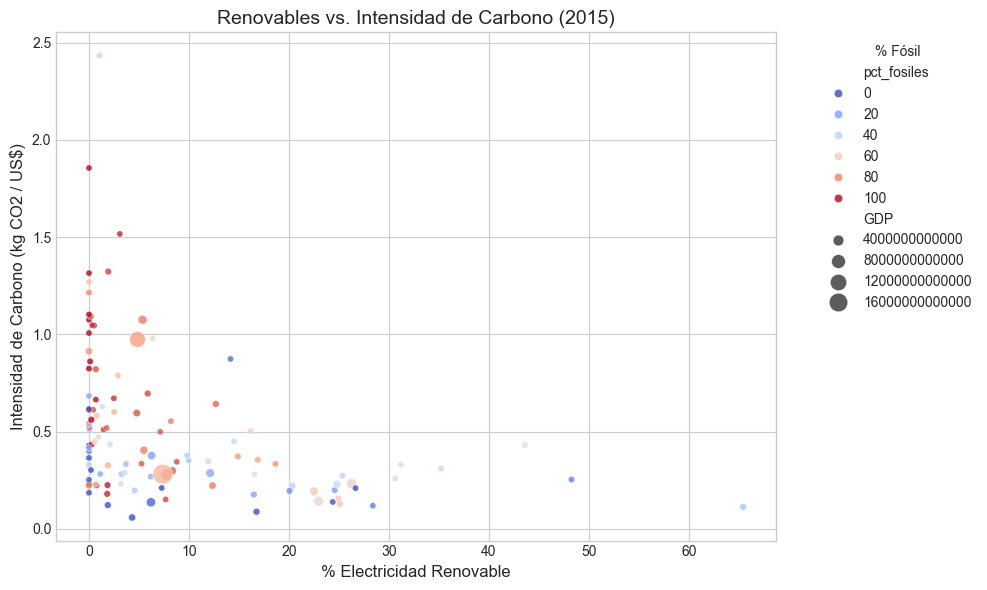

In [229]:
# ————————————————————————————————————————————————————————————————
# Celda de Código: Renovables vs. Intensidad de Carbono (scatter)
# ————————————————————————————————————————————————————————————————

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Año más reciente
yr = 2015

# 2) Filtrar y descartar filas que tengan NaN en las métricas clave
df_plot = (
    df_all[df_all['Year'] == yr]
      .dropna(subset=['pct_renovables','pct_fosiles','intensidad_constante','GDP'])
)

# 3) Scatter: eje x = % renovables, eje y = intensidad, tamaño = PIB, color = % fósil
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data    = df_plot,
    x       = 'pct_renovables',
    y       = 'intensidad_constante',
    size    = 'GDP',
    sizes   = (20, 200),
    hue     = 'pct_fosiles',
    palette = 'coolwarm',
    alpha   = 0.8
)

# 4) Etiquetas y leyenda
plt.xlabel('% Electricidad Renovable', fontsize=12)
plt.ylabel('Intensidad de Carbono (kg CO2 / US$)', fontsize=12)
plt.title(f'Renovables vs. Intensidad de Carbono ({yr})', fontsize=14)
plt.legend(title='% Fósil', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


## 7. Gráfica 2: Evolución temporal de renovables y emisiones globales


Comparamos la evolución media anual de:
- **% de electricidad renovable** (`pct_renovables`)
- **% de electricidad fósil** (`pct_fosiles`)
- **Emisiones globales de CO₂** (`CO2`)

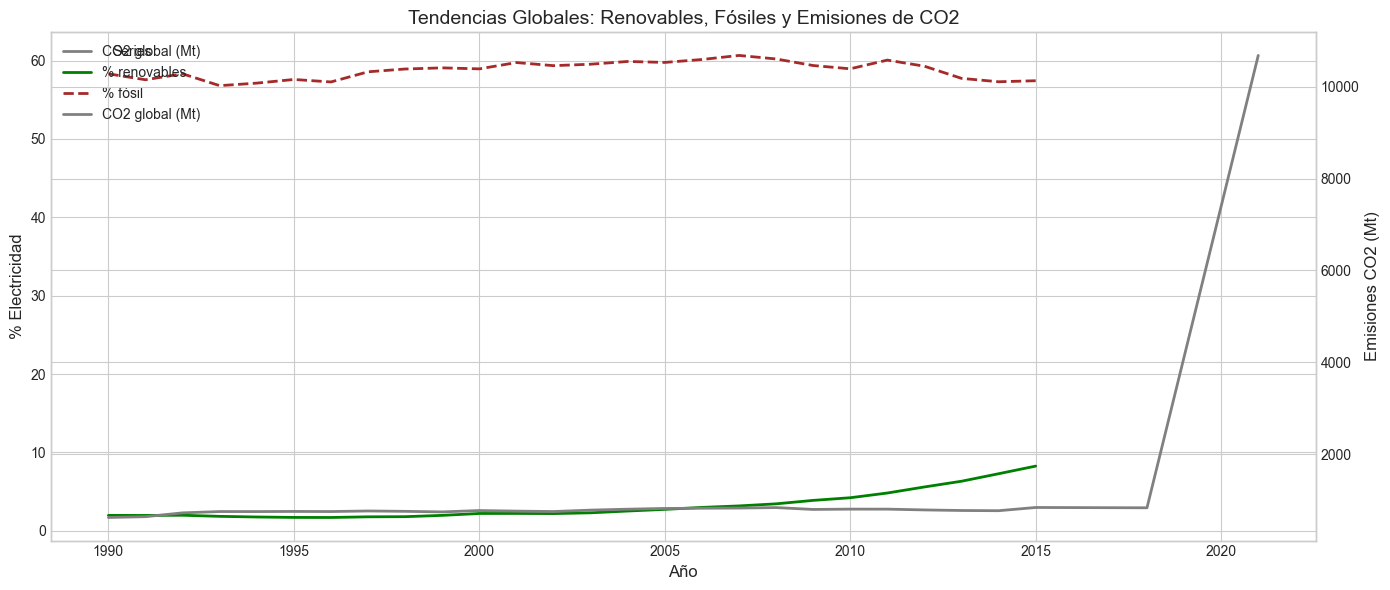

In [230]:


# 1) Calcular tendencia media anual
df_ren  = df_all.groupby("Year")["pct_renovables"].mean().reset_index()
df_fos  = df_all.groupby("Year")["pct_fosiles"].mean().reset_index()
df_co2g = df_all.groupby("Year")["CO2"].sum().reset_index()

# 2) Configurar el doble eje
fig, ax1 = plt.subplots(figsize=(14,6))
ax2 = ax1.twinx()

# 3) Dibujar renovables y fósiles en el eje izquierdo
sns.lineplot(data=df_ren,  x="Year", y="pct_renovables", ax=ax1,
             label="% renovables", color="green", linewidth=2)
sns.lineplot(data=df_fos,  x="Year", y="pct_fosiles",   ax=ax1,
             label="% fósil",      color="brown",  linewidth=2, linestyle="--")

# 4) Dibujar emisiones en el eje derecho
sns.lineplot(data=df_co2g, x="Year", y="CO2", ax=ax2,
             label="CO2 global (Mt)", color="grey", linewidth=2)

# 5) Etiquetas y leyendas
ax1.set_xlabel("Año", fontsize=12)
ax1.set_ylabel("% Electricidad", fontsize=12)
ax2.set_ylabel("Emisiones CO2 (Mt)", fontsize=12)
ax1.set_title("Tendencias Globales: Renovables, Fósiles y Emisiones de CO2", fontsize=14)

# Combinar leyendas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc="upper left", title="Series")

plt.tight_layout()
plt.show()


## 8. Gráfica 3: Matriz de correlación

Calculamos la correlación entre las variables clave para identificar relaciones fuertes.


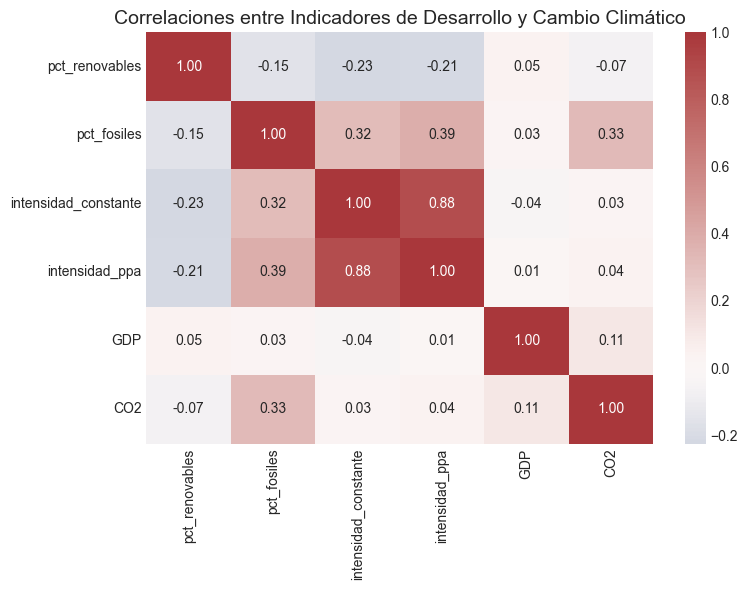

In [231]:
# Celda de Código 11: Heatmap de correlaciones (sin uso_energia_pc)
import matplotlib.pyplot as plt
import seaborn as sns

# Lista sólo con las columnas que sí existen en df_all
corr_cols = [
    "pct_renovables",
    "pct_fosiles",
    "intensidad_constante",
    "intensidad_ppa",
    "GDP",
    "CO2"
]

# Calcular matriz de correlaciones
corr = df_all[corr_cols].corr()

# Dibujar heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlaciones entre Indicadores de Desarrollo y Cambio Climático")
plt.tight_layout()
plt.show()


---

Con estos análisis podemos identificar:
- La **relación negativa** entre porcentaje de renovables y la intensidad de carbono.  
- La **evolución** a la alza de la participación renovable y, sin embargo, una reducción parcial de las emisiones globales.  
- Los **indicadores más correlacionados** con las emisiones y la eficiencia energética.  

